## Setup

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import os
import requests

from cv2 import rectangle
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [10]:
import torch

In [11]:
import tensorflow as tf
BATCH_SIZE = 16

In [12]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
from torchvision.transforms.functional import to_pil_image, to_tensor, resize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [13]:
# !wget "https://unsplash.com/photos/MXvcHk-zCIs/download?force=true&w=640" -O "img.jpg"

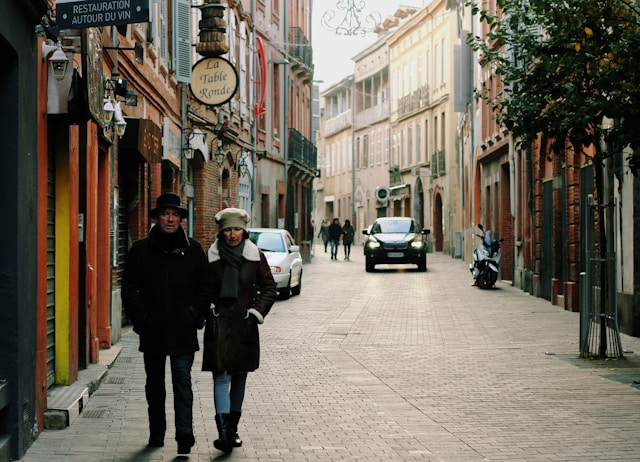

In [14]:
# street from Toulouse
url = "https://unsplash.com/photos/MXvcHk-zCIs/download?force=true&w=640"

# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open("img.jpg")

# get a torch tensor
torch_image = to_tensor(image)

# batch the image
visualizable_torch_inputs = torch_image.unsqueeze(0)

# visualize image
to_pil_image(torch_image)

In [15]:
visualizable_torch_inputs.shape

torch.Size([1, 3, 462, 640])

## Load Retinanet

In [16]:
import torchvision.transforms as T

In [17]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

nb_classes = len(CLASSES)
print(nb_classes)

91


In [ ]:
# Load Retinanet Model

from torchvision.models.detection import retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights

# Step 1: Initialize model with the best available weights
weights = RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT
model = retinanet_resnet50_fpn_v2(weights=weights) #, box_score_thresh=0.9)
model.eval()
model = model.to(device)
print('model loaded')
# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
processed_torch_inputs = preprocess(visualizable_torch_inputs).to(device)

model loaded


In [19]:
torch_predictions = model(processed_torch_inputs)[0]

In [20]:
torch_predictions.keys()

dict_keys(['boxes', 'scores', 'labels'])

## Obj Detection Wrapper

In [21]:
import torch.nn.functional as F 

In [22]:
processed_torch_inputs.shape

torch.Size([1, 3, 462, 640])

In [23]:
# from abc import ABC, abstractmethod

# class BoxesModelWrapper(torch.nn.Module, ABC):
#     # WARNING: `torch.nn.Module` specific to pytorch
#     # `tf.keras.Model` instead for tensorflow models
#     def __init__(self, model):
#         super(BoxesModelWrapper, self).__init__()
#         self.model = model.eval()

#     def __call__(self, torch_inputs):
#         # this method should change depending on the model
#         predictions = self.model(torch_inputs)
#         return torch.stack([self.format_predictions(pred) for pred in predictions], dim=0)
    
#     def forward(self, x):
#         return self.model(x)
    
#     def to(self, device):
#         # WARNING: specific to pytorch
#         self.model.to(device)
#         return self

#     def zero_grad(self):
#         # WARNING: specific to pytorch
#         self.model.zero_grad()
#         return self
    
#     @abstractmethod
#     def format_predictions(self, predictions):
#         # this method should change depending on the model
#         raise NotImplementedError("This method should be implemented in the subclass")

# class TorchvisionBoxesModelWrapper(BoxesModelWrapper):

#     def __init__(self, model):
#         super(TorchvisionBoxesModelWrapper, self).__init__(model)

#     def format_predictions(self, predictions):
#         # format prediction for them to match Xplique object detection operator
#         # a single tensor of shape (nb_boxes, 4 + 1 + nb_classes)
#         # box coordinates defined by (x1, y1, x2, y2) respectively (left, bottom, right, top).

#         labels_one_hot = F.one_hot(predictions["labels"], num_classes=nb_classes).to(predictions["labels"].device)
#         return torch.cat([predictions["boxes"],
#                           predictions["scores"].unsqueeze(dim=1),
#                           labels_one_hot],
#                          dim=1)


In [24]:
# from boxes_model_wrapper import TorchvisionBoxesModelWrapper
from xplique.utils_functions.object_detection.torch.box_model_wrapper import TorchvisionBoxesModelWrapper

od_model = TorchvisionBoxesModelWrapper(model, nb_classes=nb_classes)
results = od_model(processed_torch_inputs)

In [25]:
results.shape

torch.Size([1, 184, 96])

## Visu Retinanet

In [26]:
from xplique.plots.display_image_with_boxes import display_image_with_boxes
from xplique.utils_functions.object_detection.common.box_manager import BoxFormat

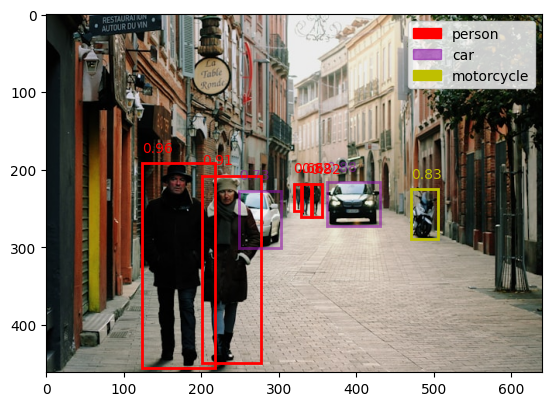

In [27]:
# class labels to color mapping
label_to_color = {'person': 'r',
                  'car': "#8F15A894",
                  'motorcycle': 'y',
                  'bicycle': 'y'}

fig = display_image_with_boxes(image, results[0].cpu().detach(), BoxFormat.XYXY, False, CLASSES, label_to_color, accuracy=0.5)

# Attribution

In [53]:
# Checks gradients
from xplique.utils_functions.object_detection.torch.gradients_check import check_model_gradients
check_model_gradients(od_model, processed_torch_inputs)

Gradients OK - sum=3118499.250000


True

Gradients OK -> we can do attribution based on gradients such as Saliency

## Saliency

In [28]:
from xplique.attributions import Saliency
from xplique.commons.operators import object_detection_operator
from xplique.wrappers import TorchWrapper

# we need to wrap our model with TorchWrapper to be able to use xplique tools with it
od_model = od_model.eval()
torch_wrapped_model = TorchWrapper(od_model, device=device, is_channel_first=True)

/home/frederic.boisnard/proj/tmp/xplique_fbo/xplique/wrappers/pytorch.py:61: UserWarning: TF is set to run eagerly to avoid conflict with PyTorch. Thus,                       TF functions might be slower
  warnings.warn("TF is set to run eagerly to avoid conflict with PyTorch. Thus,\


In [29]:
# transform torch inputs to tensorflow format
tf_inputs = visualizable_torch_inputs.permute(0, 2, 3, 1)
tf_inputs = tf_inputs.detach().cpu().numpy()
targets = torch_wrapped_model(tf_inputs)

I0000 00:00:1757090930.295711 3346606 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8245 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/frederic.boisnard/proj/tmp/xplique_fbo/xplique/wrappers/pytorch.py:141: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  torch_inputs = self.torch.Tensor(np_inputs)


In [31]:
import xplique
from xplique.attributions import Occlusion
explainer = Occlusion(torch_wrapped_model, operator=xplique.Tasks.OBJECT_DETECTION, batch_size=1, patch_size=(100, 100), patch_stride=(50, 50))

In [32]:
import xplique
operator = xplique.Tasks.OBJECT_DETECTION_BOX_PROBA
scores = operator(torch_wrapped_model, tf_inputs, targets)
print(scores)

tf.Tensor([0.25794795], shape=(1,), dtype=float32)


In [33]:
explainer = Saliency(torch_wrapped_model, operator=xplique.Tasks.OBJECT_DETECTION, batch_size=1)

In [34]:
box_to_explain = targets[:, 0]
print(f"targets.shape: {targets.shape}")
print(f"box_to_explain.shape: {box_to_explain.shape}")

targets.shape: (1, 184, 96)
box_to_explain.shape: (1, 96)


In [35]:
from xplique.utils_functions.object_detection.tf.box_manager import filter_boxes as filter_boxes_tf
box_to_explain_car = filter_boxes_tf(targets, class_id=CLASSES.index('car'))
print(len(box_to_explain_car))
print(f"box_to_explain_car[0].shape: {box_to_explain_car[0].shape}")

1
box_to_explain_car[0].shape: (24, 96)


In [36]:
try:
    explanation = explainer.explain(tf_inputs, box_to_explain)
except Exception as e:
    print("Error during explanation:", e)

Saliency.expain()
inputs type: <class 'tensorflow.python.framework.ops.EagerTensor'>
inputs shape: (1, 462, 640, 3)
inputs dtype: <dtype: 'float32'>
scores type: <class 'tensorflow.python.framework.ops.EagerTensor'>
scores shape: (1,)
scores dtype: <dtype: 'float32'>
KO scores has no requires_grad
KO inputs has no requires_grad
gradients type: <class 'tensorflow.python.framework.ops.EagerTensor'>


2025-09-05 18:50:21.724067: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


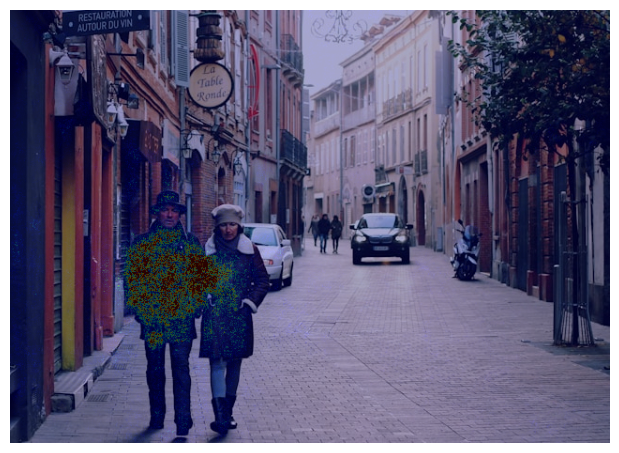

In [37]:
from xplique.plots import plot_attributions, plot_attribution

plot_attributions(explanation, tf_inputs, img_size=6.,
                cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)

## Occlusion

In [44]:
from xplique.attributions import Occlusion
explainer = Occlusion(torch_wrapped_model, operator=xplique.Tasks.OBJECT_DETECTION, batch_size=1, patch_size=(100, 100), patch_stride=(50, 50))

In [45]:
explanations = explainer.explain(tf_inputs, box_to_explain)

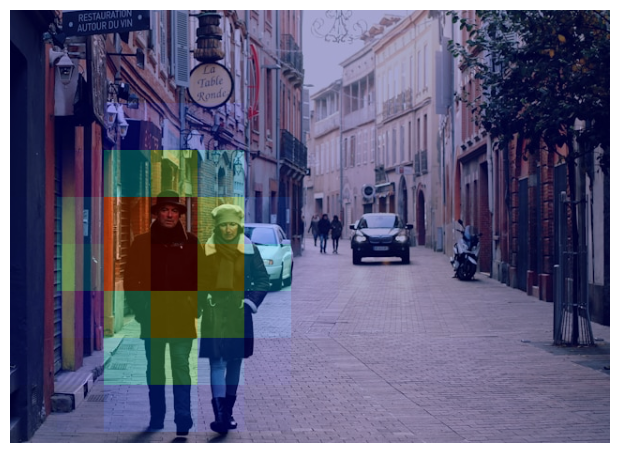

In [46]:
plot_attributions(explanations, tf_inputs, img_size=6.,
                cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)

In [47]:
boxes_to_explain = filter_boxes_tf(targets, class_id=CLASSES.index('car'))

In [48]:
explanations = explainer.explain(tf_inputs, boxes_to_explain)

2025-09-05 19:02:09.710280: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


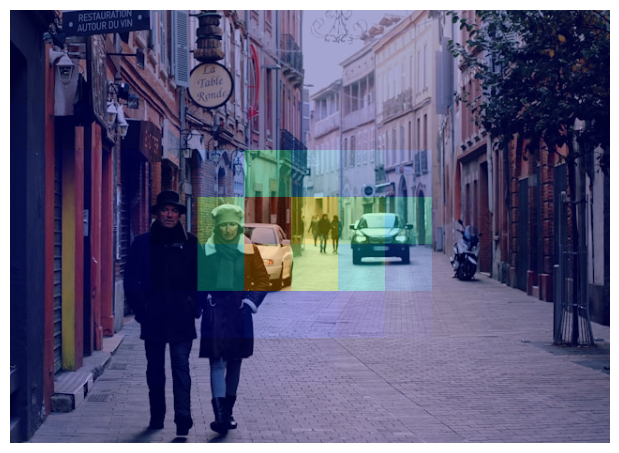

In [49]:
plot_attributions(explanations, tf_inputs, img_size=6.,
                cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)